In [262]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from nilearn.glm.first_level import glover_hrf


import os

from nilearn.input_data import NiftiMasker
from nilearn.image import load_img
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from sklearn.linear_model import ElasticNet, Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score
import nibabel as nib
from nilearn import datasets, image

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from brainextractor import BrainExtractor

from scipy.stats import zscore


In [244]:
fmri_data = []
events = []
sub = 1

for ses in range(1,5):
    for run in range(1,5):


        file = f"../data/derivatives/sub-0{sub}/ses-0{ses}/func/sub-0{sub}_ses-0{ses}_task-video_run-{run}_motion-corrected_slice-timing_bold.nii.gz"

        if not os.path.isfile(file):
            continue

        fmri_img = nib.load(file)
        fmri_data.append(fmri_img)

        events_path = f"../data/bids/sub-0{sub}/ses-0{ses}/func/sub-0{sub}_ses-0{ses}_task-video_run-{run}_events.tsv"
        events_df = pd.read_csv(events_path, sep='\t')
        events.append(events_df)

print(len(fmri_data))
print(len(events))

11
11


In [150]:
# bet = BrainExtractor(img=fmri_data[0].slicer[...,0])
anat_path = 't1w_MNI.nii.gz'
anat_img = nib.load(anat_path)


In [151]:

# anat_resampled = image.resample_to_img(anat_img, fmri_data[0])

bet = BrainExtractor(img=image.mean_img(fmri_data[0]))

bet.run()


Initializing...
Parameters: bt=0.500000, d1=20.000000, d2=10.000000, rmin=3.330000, rmax=10.000000
tmin: 0.000000, t2: 0.000000, t: 109.027087, t98: 1090.270874, tmax: 1691.787476
Center-of-Mass: [27.33284822 28.06202229 24.02436137]
Head Radius: 29.241596
Median within Head Radius: 497.828781
Initializing surface...
Brain extractor initialization complete!
Running surface deformation...
Iteration: 999
Complete.


In [152]:
bet.save_mask('mask.nii.gz')

print(type(bet.mask))
print(bet.mask.dtype)
print(bet.mask.shape)
print(np.sum(bet.mask))

<class 'numpy.ndarray'>
float64
(56, 60, 48)
75966.0


In [153]:

mask_img = nib.nifti1.Nifti1Image(bet.mask, affine=fmri_data[0].affine)
# mask_img_resampled = image.resample_to_img(mask_img, fmri_data[0], interpolation="nearest")


In [271]:
# Fetch the Harvard-Oxford atlas
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')

# Load atlas image and labels
atlas_img = atlas['maps']
labels = atlas['labels']
print(labels)

# Find the index for the Inferior Temporal Gyrus (right and left)
itg_ant_idx = labels.index('Inferior Temporal Gyrus, anterior division')
itg_post_idx = labels.index('Inferior Temporal Gyrus, posterior division')
itg_occ_idx = labels.index('Inferior Temporal Gyrus, temporooccipital part')

# Create masks for the ITG
itg_ant_mask = image.math_img(f'img == {itg_ant_idx}', img=atlas_img)
itg_post_mask = image.math_img(f'img == {itg_post_idx}', img=atlas_img)
itg_occ_mask = image.math_img(f'img == {itg_occ_idx}', img=atlas_img)


# Combine both masks into one (optional)
itg_mask = image.math_img('img1 + img2 + img3', img1=itg_ant_mask, img2=itg_post_mask, img3=itg_occ_mask)

['Background', 'Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)', 'Subcallosal Cortex', 'Paracingulate

In [245]:

# fmri_data_aligned = []

# for img in tqdm(fmri_data):
#     if not (img.affine==fmri_data[0].affine).all():
#         img = nib.nifti1.Nifti1Image(img.get_fdata(), affine=fmri_data[0].affine)
#     fmri_data_aligned.append(img)


100%|██████████| 11/11 [00:00<00:00, 368.23it/s]


In [283]:
from nilearn.maskers import MultiNiftiMasker

masker = MultiNiftiMasker(
    standardize=True,
    detrend=True,
    mask_img=itg_mask, fmri_data[0], interpolation="nearest")  #mask_img
    )

masker.fit(fmri_data)

c:\Users\dariu\AppData\Local\Programs\Python\Python38\lib\site-packages\nilearn\maskers\multi_nifti_masker.py:234: UserWarning: [MultiNiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask has been provided at masker creation. Given mask will be used.
  warnings.warn(


MultiNiftiMasker(detrend=True,
                 mask_img=<nibabel.nifti1.Nifti1Image object at 0x0000029AABF537F0>,
                 standardize=True)

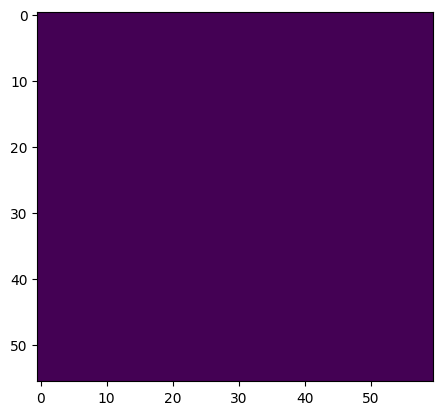

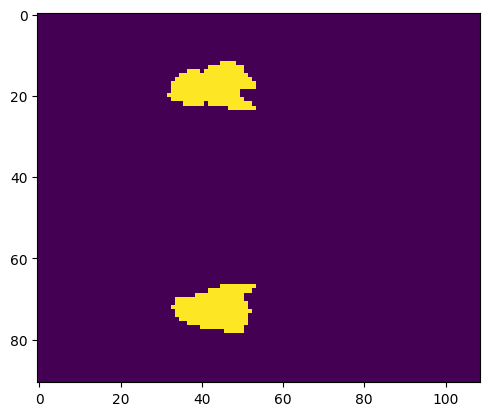

In [296]:
# plt.imshow(fmri_data[0].get_fdata()[:,:,25,0])
# plt.show()
# plt.imshow(fmri_data[2].get_fdata()[:,:,25,0])
# plt.show()
# plt.imshow(anat_img.get_fdata()[:,:,80])
# plt.show()
# plt.imshow(mask_img.get_fdata()[:,:,25])
# plt.show()
# plt.imshow(mask_img_resampled.get_fdata()[:,:,25])
# plt.show()
mask_resampled = image.resample_to_img(itg_mask, anat_img, interpolation="nearest")
plt.imshow(image.resample_to_img(mask_resampled, fmri_data[0], interpolation="nearest").get_fdata()[:,:,10])
plt.show()
plt.imshow(itg_mask.get_fdata()[:,:,25])
plt.show()

In [247]:
fmri_masked = []

# x, y, z, t = fmri_data[0].shape


for img in tqdm(fmri_data):

    masked_data = masker.transform(img)
    fmri_masked.append(masked_data)
    # masked_data = img.get_fdata().astype("float16").reshape(x*y*z, t).T
    # fmri_masked.append(masked_data)

    # masked_data = img.get_fdata() * bet.mask[..., np.newaxis]
    # fmri_masked.append(masked_data)

100%|██████████| 11/11 [01:06<00:00,  6.01s/it]


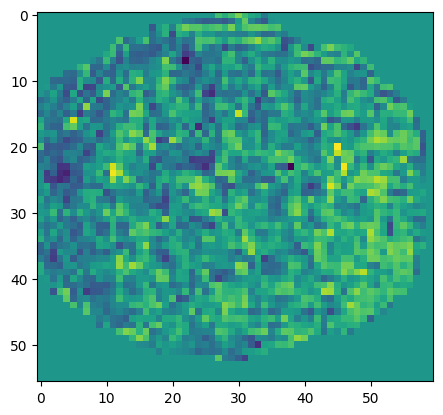

In [163]:
# plt.imshow(masker.inverse_transform(fmri_masked[0]).get_fdata()[:,:,20,100])



In [248]:

tr = 0.867

print(fmri_data[0].shape)
# Define the frame times
frame_times = np.arange(fmri_data[0].shape[3]) * tr  # Adjust the TR as per your data
ratings_convolved = []

for i in range(len(fmri_data)):
    # Create the design matrix
    
    events_temp = events[i]
    events_temp['modulation'] = events_temp['disgust']
    design_matrix = make_first_level_design_matrix(
        frame_times, events_temp, hrf_model='glover', drift_model='cosine', high_pass=0.01
    )

    # Ensure the design matrix and fMRI data are aligned
    assert fmri_data[0].shape[3] == design_matrix.shape[0]

    # print(design_matrix.head())
    # plot_design_matrix(design_matrix)

    # Extract the convolved ratings
    ratings_convolved_temp = zscore(design_matrix['dummy'].values)
    ratings_convolved.append(ratings_convolved_temp)

(56, 60, 48, 1025)
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


c:\Users\dariu\AppData\Local\Programs\Python\Python38\lib\site-packages\nilearn\glm\first_level\experimental_paradigm.py:129: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn(
c:\Users\dariu\AppData\Local\Programs\Python\Python38\lib\site-packages\nilearn\glm\first_level\experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: fear, cute, category, file, disgust
  warnings.warn(
c:\Users\dariu\AppData\Local\Programs\Python\Python38\lib\site-packages\nilearn\glm\first_level\experimental_paradigm.py:129: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn(
c:\Users\dariu\AppData\Local\Programs\Python\Python38\lib\site-packages\nilearn\glm\first_level\experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: fear, cute, category, file, disgust
  warnings.warn(
c:\Users\dariu\AppData\Local\Programs\Python\Python38\lib\site

A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


c:\Users\dariu\AppData\Local\Programs\Python\Python38\lib\site-packages\nilearn\glm\first_level\experimental_paradigm.py:129: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn(
c:\Users\dariu\AppData\Local\Programs\Python\Python38\lib\site-packages\nilearn\glm\first_level\experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: fear, cute, category, file, disgust
  warnings.warn(
c:\Users\dariu\AppData\Local\Programs\Python\Python38\lib\site-packages\nilearn\glm\first_level\experimental_paradigm.py:129: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn(
c:\Users\dariu\AppData\Local\Programs\Python\Python38\lib\site-packages\nilearn\glm\first_level\experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: fear, cute, category, file, disgust
  warnings.warn(


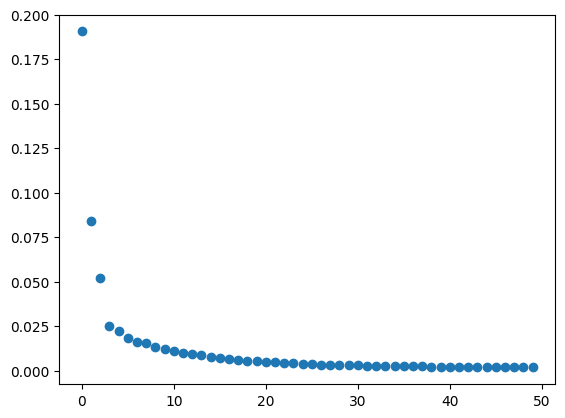

In [252]:
pca = PCA(n_components=50)

principal_components = pca.fit_transform(fmri_masked[0])

plt.plot(np.arange(principal_components.shape[1]), pca.explained_variance_ratio_, 'o')


pc_transforms = [pca.transform(fmri_x) for fmri_x in fmri_masked]



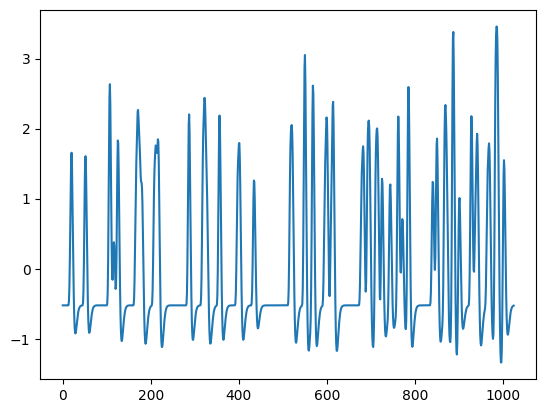

In [168]:
# plt.plot(ratings_convolved[2])

In [184]:
model = ElasticNet(alpha=1.0)

model.fit(pc_transforms[0], ratings_convolved[0])

y_pred = model.predict(pc_transforms[0])

r = np.corrcoef(y_pred, ratings_convolved[0])[0,1]
print(r)

0.44662226094972063


In [206]:
def compute_power_spectrum(signal, fs):
    """Compute the power spectrum of a signal."""
    fft_vals = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), 1/fs)
    power_spectrum = np.abs(fft_vals)**2
    return freqs, power_spectrum

def generate_surrogate_waveform(original_signal):
    """Generate a surrogate waveform with a similar power spectrum."""
    fs = len(original_signal)  # Assume original signal is sampled at Nyquist frequency
    freqs, power_spectrum = compute_power_spectrum(original_signal, fs)
    
    # Generate random phase values
    random_phases = np.exp(1j * np.random.uniform(0, 2*np.pi, len(freqs)))
    
    # Reconstruct surrogate waveform
    surrogate_fft = np.sqrt(power_spectrum) * random_phases
    surrogate_signal = np.fft.ifft(surrogate_fft).real
    
    return surrogate_signal

In [298]:
time_series_r2 = []
trial_r2 = []

for i in range(len(fmri_data)-1):

    # pca = PCA(n_components=100)

    # pca.fit(np.vstack(fmri_masked[:i+1]))

    # pc_transforms = [pca.transform(fmri_x) for fmri_x in fmri_masked]

    model = Ridge(alpha=100)

    # model.fit(np.vstack(pc_transforms[:i+1]), np.concatenate(ratings_convolved[:i+1]))
    # model.fit(pc_transforms[0], ratings_convolved[0])

    selected_columns = np.random.choice(fmri_masked[0].shape[1], 7000, replace=False)
    selected_matrix = np.vstack(fmri_masked[:i+1])[:, selected_columns]

    model.fit(selected_matrix, np.concatenate(ratings_convolved[:i+1]))


    # y_pred = model.predict(pc_transforms[i+1])
    y_pred = model.predict(fmri_masked[i+1][:, selected_columns])

    # y_pred = generate_surrogate_waveform(y_pred)

    # r = np.corrcoef(y_pred, ratings_convolved[0])[0,1]
    # print(r)
    # print(i)
    # y_pred = model.predict(pc_transforms[i])

    # r = np.corrcoef(y_pred, ratings_convolved[i+1])[0,1]
    r2 = r2_score(ratings_convolved[i+1], y_pred=y_pred)

    print(r2)
    time_series_r2.append(r2)

    window = int(12 / tr)
    events_temp = events[i+1]

    # print(events_temp.shape)

    scores = np.zeros(200)

    for k, row in events_temp.iterrows():
        onset = int(row['onset'])
        in_tr = int(onset / tr)
        # data_start = np.min((1024, in_tr + int(3 / tr)))
        data_end = np.min((1024, in_tr + window))

        data_window = y_pred[in_tr:data_end]
        if data_end >= 1024:
            scores[k] = 0
        else:
            # comparison_window = y_pred[data_start:in_tr]
            hrf = glover_hrf(tr=tr, oversampling=1, time_length=32)[:window]
            score = np.dot(data_window, hrf)
            # score = np.sum(data_window)# - np.mean(comparison_window))
            scores[k] = score

    ratings = events_temp['disgust']
    r2 = np.corrcoef(scores, ratings)[0,1] ** 2
    print(r2)
    trial_r2.append(r2)

    # plt.plot(ratings_convolved[i][:200])
    # plt.plot(y_pred[:200])
    # plt.show()

-0.07861704854720863
0.04043368254077196
-0.02357121754357827
0.05276567772836504
-2.1782794866010216
0.005099456784879155
-1.4835103350950698
0.0003667775205520348


c:\Users\dariu\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=4.73105e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


-0.6701631303018207
0.004895240757337042


c:\Users\dariu\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_ridge.py:237: LinAlgWarning: Ill-conditioned matrix (rcond=4.50131e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


-2.5096089402810855
0.0010024720779654296
-1.3878673020368426
0.05772776393252292
-2.217860507307566
0.012382052058535487
-3.0805432948764606
0.0003448972286298871
-2.6969972023880224
0.004953880942520063


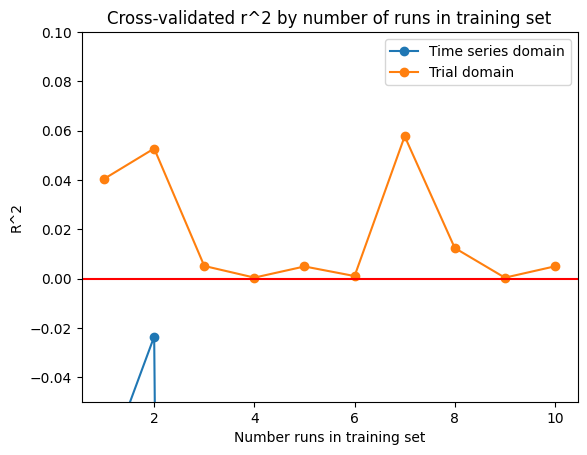

In [299]:
plt.plot(range(1,11), time_series_r2, 'o-', label="Time series domain")
plt.plot(range(1,11), trial_r2, 'o-', label="Trial domain")
plt.ylim((-0.05, 0.1))
plt.axhline(0, color='r')
plt.legend()
plt.title("Cross-validated r^2 by number of runs in training set")
plt.ylabel("R^2")
plt.xlabel("Number runs in training set")
plt.show()

